<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

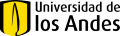

<span style="font-family:Cambria Math">
    
# Mini Proyecto 1, Técnica de *Deep Learning*: Clasificación de MRI con Redes Neuronales Convolucionales para Tipos de Cáncer

## Descripción del problema:

La **resonancia magnética** (MRI) es clave para detectar y clasificar tumores cerebrales. Gracias a las redes neuronales convolucionales (CNN), hoy podemos analizar estas imágenes con gran precisión, ya que las CNN aprenden a reconocer los patrones propios de cada tipo de tumor.

Un estudio completo de MRI genera un volumen 3D formado por muchas **capas bidimensionales**. Procesar el volumen entero resulta costoso en tiempo y recursos.

Para este proyecto abordaremos el problema de forma más ligera: trabajaremos solo con las imágenes 2D extraídas de cada capa. Así reducimos la carga computacional y convertimos la tarea en una clasificación de imágenes individuales, sin perder la información esencial para el diagnóstico.

## Objetivo:

Desarrollar un método basado en redes neuronales convolucionales que permita
clasificar con exactitud imágenes extraídas de MRIs en una de las 4 categorías.

- **Glioma**: Detecta masas anómalas con bordes irregulares y heterogeneidad en
el tejido cerebral.
- **Meningioma**: Identifica tumores bien delimitados originados en las meninges.
- **Pituitary**: Clasifica adenomas hipofisarios en la región selar.
- **Tejido sano**: Diferencia el tejido cerebral normal sin anomalías presentes

## Resumen:

Este notebook documenta la exploración y el preprocesamiento de un dataset de imágenes MRI (Brain Tumor), así como el entrenamiento, la validación con *early stopping* y la prueba de una adaptación y *fine-tuning* de la arquitectura CNN AlexNet, en su versión de PyTorch.

*****
</span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 2 de mayo.**

Tareas:

* Ajustar el código para tomar un solo canal (Andrés Ñungo) ✅
* Tomar los papers investigar en la teoría como se debería ver un cerebro enfermo (Andrés Ñungo)
* Mejorar la explicación del código
* Confirmar que las carpetas descargadas este a nivel del main
* Organizar las referencias bibliográficas (Jordan) ✅
* Referenciar / mencionarlas las imágenes / plots (Andrés)
* Mapa de características (Andrés y Jordan)
* Explicación de la carga lazy en el PDF (Jordan)
* En la metodología dentro del PDF:
  - Hasta evaluación (Jordan)
  - Evaluación (Andrés)
* Número de parámetros (Andrés)
* Matriz de confusión (Andrés)
* Gráfica Accuracy /Loss vs epochs

Pendientes potenciales:
* Un plot de los que nos enseñaron sobre la arquitectura de la red convolucional

* Sería bueno sacar unas mini capas que muestren en conjunto la evolución de la imágen a medida que pasa por los diferentes kernels inspiración: https://poloclub.github.io/cnn-explainer/

</div24></span>

<span style="font-family:Cambria Math">

***
    
# Índice
El *notebook* abordará el proyecto de la siguiente manera:

1. [Instalación y carga de librerías](#instalacion-y-carga-de-librerias)

2. [Análisis exploratorio y preparación de los datos](#analisis-exploratorio-y-preparacion-de-los-datos)

3. [Definición de *pipelines* de preprocesamiento](#definicion-de-pipelines-de-preprocesamiento)

  3.1 [Pipeline de Preprocesamiento](#pipeline-de-preprocesamiento)

  3.2 [Carga lazy de los datos mediante la clase ImgDataset](#carga-lazy-de-los-datos-mediante-la-clase-imgdataset)

7. [Referencias](#referencias)
</span>

***

<span style="font-family:Cambria Math">

# 1. Instalación y cargue de librerías
</span>

<span style="font-family:Cambria Math">

Empezamos por el cargue de las librerias que se usarán para efectos de este proyecto. Estas incluyen:

* Librerías comunes para la lectura, procesamiento y ploteo básico de las imágenes.
* **`kagglehub`**, para poder descargar el dataset del miniproyecto de forma conveniente
* **`pytorch`** (de acuerdo, a la sugerencia del enunciado del proyecto), y particularmente su variante para visión computacional **`torchvision`**, ya que es una de las librerías más conocidas e intuitivas para trabajar el problema de clasificación de imágenes con CNNs[¹].

El uso específico de las librerías se detallará a medida que desarrollemos el notebook.

Adicionalmente nos aseguramos de ignorar alertamientos y de imprimir las versiones de las librerías usadas para que el ejercicio pueda ser replicable más adelante.
</span>

In [1]:
# Librerías comunes
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import hashlib
import random

# Obtención de la información
import kagglehub

# Modelado
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import copy

# Evaluación ❓️
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ['numpy', 'pandas', 'torch', 'torchvision', 'scikit-learn']
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
torchvision :  0.21.0+cu124
scikit-learn :  1.6.1


In [3]:
# Definición del random state
RANDOM_STATE = 13

# Definición de semillas
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

***
<span style="font-family:Cambria Math">

# 2. Análisis exploratorio y preparación de los datos

En primer lugar, nos encargamos de descargar correctamente las imágenes, teniendo en cuenta que vienen en carpetas separadas. Desde nuestra perspectiva, la mejor manera de organizar la información es vía un *dataframe*, cuya primera columna tenga la ruta de la imágen y en la segunda columna su respectiva etiqueta.

Almacenar solo las rutas de las imágenes nos permitirá cargar los datos solo cuando sean necesarios. Esto se detalla posteriormente en la sección **Pipeline de Preprocesamiento**.
</span>

In [4]:
# Descargar el conjunto de datos y almacenar el path en una variable
os.environ['KAGGLEHUB_CACHE'] = os.getcwd()
path_kaggle = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print("Ruta:", path_kaggle)

100%|██████████| 236M/236M [00:01<00:00, 147MB/s]

Extracting files...


Ruta: /content/datasets/rm1000/brain-tumor-mri-scans/versions/1


In [5]:
# Definición de labels a cargar
labels = ['glioma', 'healthy', 'meningioma', 'pituitary']
num_labels = len(labels)

# Indexamos cada label y también generamos el diccionario en sentido contrario
label2idx = {label: idx for idx, label in enumerate(labels)}
idx2label = {v: k for k, v in label2idx.items()}

# Por cada label, generar el path de su directorio
path_raiz = path_kaggle
path_por_label = {label: os.path.join(path_raiz, label) for label in labels}

# Dataframe con los paths de las imágenes y su label correspondiente
df_paths = []
for label, path in path_por_label.items():
    imagenes = os.listdir(path)
    for img in imagenes:
        # Solo procesar imágenes JPG
        if img.lower().endswith('.jpg'):
            img_path = os.path.join(path, img)
            df_paths.append({'img_path': img_path, 'label': label})
df_paths = pd.DataFrame(df_paths)

# Verificar dataframe
df_paths.sample(5)

,img_path,label
6442,/content/datasets/rm1000/brain-tumor-mri-scans...,pituitary
2531,/content/datasets/rm1000/brain-tumor-mri-scans...,healthy
4180,/content/datasets/rm1000/brain-tumor-mri-scans...,meningioma
3149,/content/datasets/rm1000/brain-tumor-mri-scans...,healthy
5592,/content/datasets/rm1000/brain-tumor-mri-scans...,pituitary


***
<span style="font-family:Cambria Math">

Una vez teniendo esta información pre-cargada, hacemos un breve análisis de nuestro conjunto de datos. Empezando por la distribución de las clases:
</span>

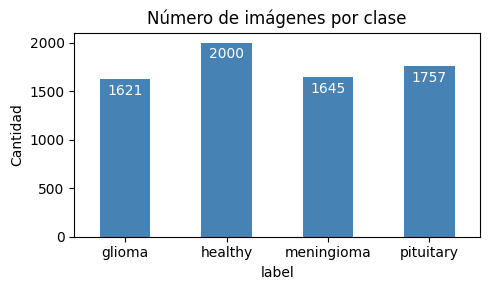

In [6]:
# Verificación de la distribución de las clases
counts = df_paths['label'].value_counts().sort_index()

# Gráfica con etiquetas numéricas
ax = counts.plot(kind='bar', rot=0, figsize=(5,3), color='steelblue')
ax.set_title('Número de imágenes por clase'); ax.set_ylabel('Cantidad')

# Añadir la etiqueta de cantidad encima de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height() - 50),
                ha='center', va='top', fontsize=10, color='white')
plt.tight_layout(); plt.show()

***
<span style="font-family:Cambria Math">

Se puede observar que no hay sobre o sub-representación de las clases en el conjunto de datos original. Solo se observa una leve mayoría en el conjunto **`healthy`**.

Para tener una idea de cómo se visualizan las imágenes dependiendo de la clasificación de los tumores, se hace un mapeo de un mosaico muy sencillo sobre las muestras en el conjunto *brain tumor MRI*.
</span>

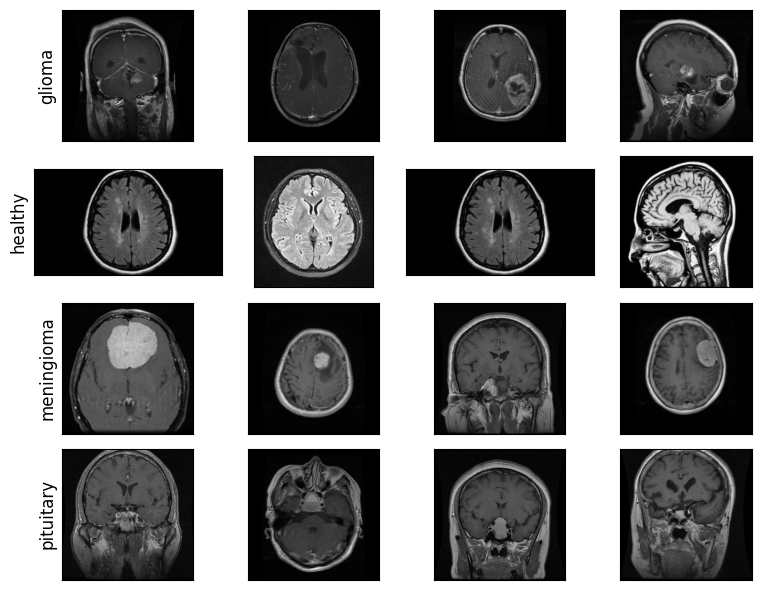

In [7]:
# Mosaico de muestras
fig, axes = plt.subplots(num_labels, 4, figsize=(8, 6))
for c, label in enumerate(labels):
    sample_paths = df_paths[df_paths.label == label].sample(4, random_state=RANDOM_STATE)['img_path']
    for r, p in enumerate(sample_paths):
        axes[c, r].imshow(Image.open(p))
        axes[c, r].set_yticklabels([]); axes[c, r].set_xticklabels([]);
        axes[c, r].set_yticks([]); axes[c, r].set_xticks([]);
        r == 0 and axes[c, r].set_ylabel(label, fontsize=12)
plt.tight_layout()
plt.show()

***
<span style="font-family:Cambria Math">

Por otro lado, es importante visualizar la resolución y proporción de aspecto (*aspect ratio*) de las imágenes para identificar características inusuales (*outliers*).
</span>

Text(0.5, 1.02, 'Distribución de resoluciones')

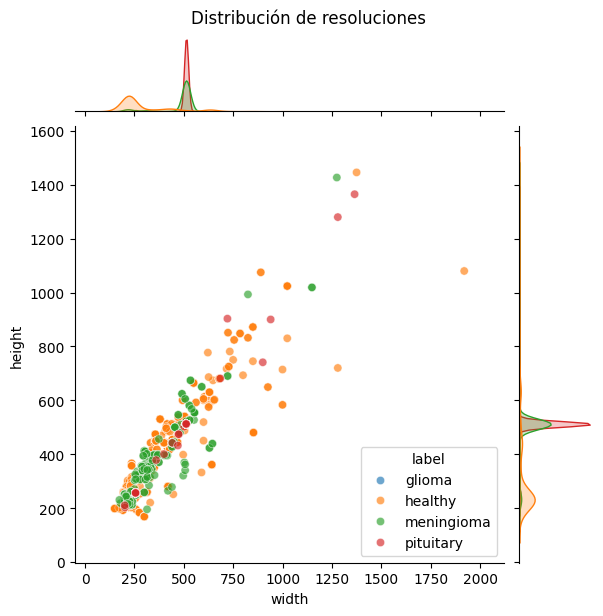

In [8]:
# Devuelve el tamaño (ancho x altura) de cada imágen
def get_size(path):
    with Image.open(path) as im:
        return im.size
df_paths[['width', 'height']] = df_paths['img_path'].apply(lambda p: pd.Series(get_size(p)))

# Jointplot
ax = sns.jointplot(data=df_paths, x='width', y='height', height=6, hue=df_paths['label'], alpha=0.65)
sns.move_legend(ax.ax_joint, "lower right")
plt.suptitle('Distribución de resoluciones', y=1.02)

<span style="font-family:Cambria Math">


- **Agrupación principal**: la mayoría de las imágenes se concentran entre 200 px y 500 px en ambos ejes, formando una nube diagonal que evidencia una relación de aspecto casi constante.  
- **Outliers**: unos pocos archivos superan los 1000 px; son imágenes mucho más grandes que el resto.

Para unificar el conjunto se aplicará un **`resize`** uniforme. Como las proporciones se mantienen estables, el escalado eliminará la varianza sin distorsionar el contenido; se pierde algo de detalle, pero se gana homogeneidad.

Después del redimensionamiento se calcularán la **media** y la **desviación estándar** globales de los canales. Esta normalización suavizará las variaciones de iluminación detectadas.

A continuación, confirmamos que el formato de los canales de las imágenes sean RGB:

</span>

In [9]:
# Verificación de canales
modes = df_paths['img_path'].apply(lambda p: Image.open(p).mode)
print(modes.value_counts())

img_path
RGB    7023
Name: count, dtype: int64


<span style="font-family:Cambria Math">

Antes de calcular la media y la desviación estándar para efectos de la normalización conviene mencionar que las MRI T1 con contraste no contienen información cromática real; los tres canales son copias o casi copias de la misma señal de luminancia[²]. Por lo que es conveniente trabajar en escalas de grises, ya que no se pierde mucha información y permite reducir el uso de memoria.

Procedemos entonces a definir una función para dicho cálculo:
</span>

In [10]:
# Función para obtener la media y desviación estándar de grises para la normalización
def gray_mean_std(df):
  gray_sum, gray_sq_sum, pixel_count = 0.0, 0.0, 0

  for p in df['img_path']:
      img = np.asarray(Image.open(p).convert('L'), dtype=np.float32) / 255.0  # [0, 1]

      gray_sum     += img.sum()          # suma de intensidades
      gray_sq_sum  += (img ** 2).sum()   # suma de intensidades al cuadrado
      pixel_count  += img.size           # número de píxeles (alto × ancho)

  gray_mean = gray_sum / pixel_count
  gray_std  = np.sqrt(gray_sq_sum / pixel_count - gray_mean ** 2)

  print(f"Media global (grayscale): {gray_mean:.5f}")
  print(f"Desv. estándar global:    {gray_std:.5f}")

  return gray_mean, gray_std

In [11]:
gray_mean, gray_std = gray_mean_std(df_paths)

Media global (grayscale): 0.17375
Desv. estándar global:    0.18941


<span style="font-family:Cambria Math">

Esta media y desviación estándar serán utilizadas en el proceso de normalización que nos permite centrar en 0 y tener un varianza unitaria, lo que desde el punto de vista teórico mitiga el riesgo desvanecimiento del gradiente o de explosión respectivamente[³].

Finalmente, para terminar con esta fase exploratoria, verificamos si hay duplicados para evitar la sobre-representación. Para ello se usa **`hashlib`**, librería que permite calcular la huella digital SHA-256 en las imágenes. Su propósito principal es generar una clave única de longitud fija (256 bits = 32 bytes = 64 caracteres hexadecimales) a partir de cualquier bloque de datos. Este es un método común e intuitivo para identificar duplicados[⁴].

</span>

In [12]:
# Verificación de duplicado de datos
def sha256_file(path):
    with open(path, 'rb') as f:
        return hashlib.sha256(f.read()).hexdigest()

hashes = df_paths['img_path'].apply(sha256_file)
duplicados = hashes[hashes.duplicated(keep=False)]
print(f'Duplicados detectados: {duplicados.shape[0]}')

Duplicados detectados: 726


<span style="font-family:Cambria Math">

Tenemos **726** duplicados identificados por huella SHA-256, lo que sugiere que podríamos estar incurriendo en una ligera sobre-representación de alguna clase. Por tal motivo, limpiaremos el dataset dejando solo una instancia de las imágenes duplicadas.

El  dataset todavía tendrá suficientes imágenes únicas para entrenar una CNN. Por simplicidad metodológica eliminamos duplicados manteniendo solo la primera instancia. Note que son **726** **filas marcadas duplicadas**; si nos quedamos con el grupo de duplicados con un representante, la cantidad de datos limpios es mayor a la resta entre **7.023** y **726**.
</span>

In [13]:
# Calcula hash de cada fila
df_paths['hash'] = df_paths['img_path'].apply(sha256_file)

# Mantén la primera aparición de cada hash
df_clean = df_paths.drop_duplicates(subset='hash', keep='first').reset_index(drop=True)

print(f"Tamaño original: {len(df_paths):,}")
print(f"Tamaño limpio  : {len(df_clean):,}")

Tamaño original: 7,023
Tamaño limpio  : 6,597


Al plotear nuevamente la distribución de clases, notamos que la mayoría de imágenes duplicadas corresponden principalmente a la categoría `healthy`, y ligeramente a la categoría `meningioma`:

Reducción de 1 para glioma
Reducción de 294 para healthy
Reducción de 114 para meningioma
Reducción de 17 para pituitary


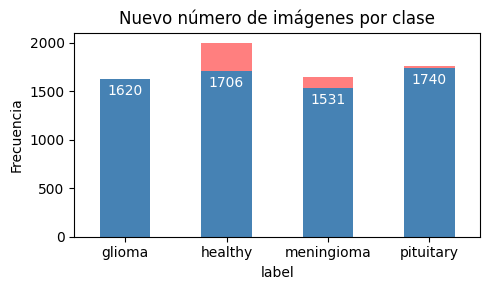

In [14]:
# Verificación de la distribución de las clases
counts = df_paths['label'].value_counts().sort_index()
counts_clean = df_clean['label'].value_counts().sort_index()
[print(f"Reducción de {a - b} para {labels[i]}") for i, (a, b) in enumerate(zip(counts,counts_clean))]

# Gráfica con etiquetas numéricas
ax = counts.plot(kind='bar', rot=0, figsize=(5,3), color='red', alpha=0.5)
counts_clean.plot(kind='bar', rot=0, color='steelblue')
ax.set_title('Nuevo número de imágenes por clase')
ax.set_ylabel('Frecuencia')

# Añadir la etiqueta de cantidad encima de cada barra
for p in ax.patches[4:]:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height() - 50),
                ha='center', va='top', fontsize=10, color='white')
plt.tight_layout(); plt.show()

La siguiente fución nos permitirá observar pares aleatorios de imágenes duplicadas, así como sus correspondientes nombres de archivo:

In [15]:
# Plotear aleatoriamente la primera y última ocurrencia de una imagen duplicada
def mostrar_duplicadas(df):

    # Filas con más de un hash count
    hash_counts = df['hash'].value_counts()
    duplicadas = hash_counts[hash_counts > 1].index

    # Elegir aleatoriamente
    hash_random = random.choice(duplicadas)
    grupo_duplicado_paths = df.loc[df['hash'] == hash_random, 'img_path']
    primera, ultima = [grupo_duplicado_paths.iloc[0], grupo_duplicado_paths.iloc[-1]]

    # Plot
    print("Imágenes duplicadas:")
    print("Primera ocurrencia:", primera); print("Última ocurrencia:", ultima)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(Image.open(primera)); ax1.axis('off')
    ax2.imshow(Image.open(ultima)); ax2.axis('off')
    plt.show()

Para el dataframe con duplicados, la función debe mostrar el par aleatorio de imágenes. Para el dataframe, debería ocurrir un `IndexError`:

Imágenes duplicadas:
Primera ocurrencia: /content/datasets/rm1000/brain-tumor-mri-scans/versions/1/pituitary/0900.jpg
Última ocurrencia: /content/datasets/rm1000/brain-tumor-mri-scans/versions/1/pituitary/1096.jpg


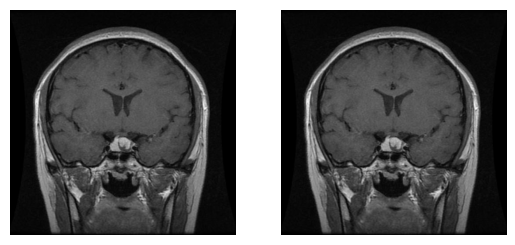

In [16]:
mostrar_duplicadas(df_paths)

In [17]:
# Pass
try:
  mostrar_duplicadas(df_clean)
except IndexError:
  print("df_clean no contiene imágenes duplicadas")

df_clean no contiene imágenes duplicadas


<span style="font-family:Cambria Math">

Nuevamente es necesario calcular la media y desviación estándar de nuestros datos, esta vez con la limpieza hecha.
</span>

In [18]:
gray_mean, gray_std = gray_mean_std(df_clean)

Media global (grayscale): 0.17168
Desv. estándar global:    0.18712


***
<span style="font-family:Cambria Math">

# 3. Definición de *pipelines* de preprocesamiento

A continuación se definen los *pipelines* de preprocesamiento que permitirán ajustar las imágenes a un formato más adecuado y procesable para la red neuronal.

</span>

***

<span style="font-family:Cambria Math">

## 3.1 Pipeline de Preprocesamiento

Como base para el preprocesamiento se utiliza un estándar recomendado para la red de *AlexNet* [⁵], que permite alistamiento y aumento de los datos aumento de los datos a partir de los siguientes pasos:

*  Transformar a escala de grises para garantizar un solo canal, y a la vez reducir el uso de memoria sin perder información cromática.

* Ajuste del tamaño de las imágenes a 224 x 224 pixeles

* **`CenterCrop`**

* Transformaciones de *data augmentation* para generar variaciones espaciales (espejo horizontal y rotaciones de ±15°) que ayudan a la red a generalizar.

* **`ToTensor`** transformación al objeto tomado por defecto en las herramientas de **`Pytorch`**

* Normalización de los datos restando media y dividiendo sobre la desviación estándar para reducir el riesgo de gradiente pequeño o explosivo.


</span>

In [62]:
# Pipeline de preprocesamiento recomendado
transform_pipeline = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.RandomRotation(15),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((gray_mean,), (gray_std,))
])

***

<span style="font-family:Cambria Math">

## 3.2 Carga lazy de los datos mediante un subtipo de la clase Dataset

La siguiente clase de PyTorch permite cargar las imágenes utilizando lazy evaluation[⁶][⁷]. Esto hace que los datos se lean *justo a tiempo*—solo cuando `getitem` (e.g., `dataset[idx]`) es invocado por el `DataLoader`— en lugar de cargarlos todos en la memoria al iniciar el entrenamiento.

De este modo, se optimiza el uso de la RAM del CPU y se evita la saturación de la memoria de la GPU al enviar únicamente un batch a la vez.

</span>



In [20]:
# Subclase de Dataset (PyTorch) para cargar más eficientemente la data -> Lazy evaluation
class ImgDataset(Dataset):
  def __init__(self, df, transformacion, label2idx:dict = None):
    self.df = df
    self.transformacion = transformacion
    self.label2idx = label2idx

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    fila = self.df.iloc[idx]
    img_path = fila['img_path']
    label = fila['label']

    # Si se pasa label2idx, estos se convierten a índices con base en label2idx
    if self.label2idx:
      label = self.label2idx[label]

    # Leer imagen y aplicar transformación custom
    with Image.open(img_path) as img:
      img = self.transformacion(img)

    return img, label

In [21]:
# Instanciación de la clase de Dataset
dataset = ImgDataset(df_clean, transformacion=transform_pipeline, label2idx=label2idx)

In [22]:
# Ejemplo de una carga individual
random_idx = random.randint(0,len(dataset))
tensor, etiqueta = dataset[random_idx]
print("Dimensiones estandar de imagen con un solo canal: ", tensor.shape)
print("Etiqueta numérica: ", etiqueta)

Dimensiones estandar de imagen con un solo canal:  torch.Size([1, 224, 224])
Etiqueta numérica:  1


***
<span style="font-family:Cambria Math">

Plotear una imagen a partir de un tensor:

</span>

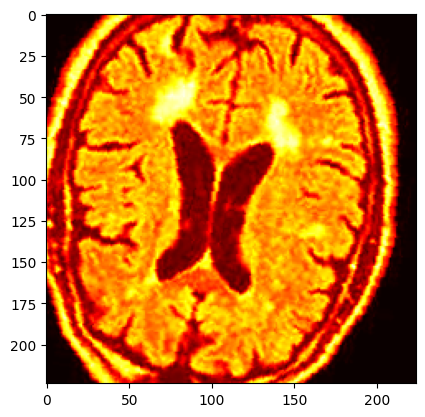

In [23]:
# Convertir de Tensor a Numpy
def tensor2numpy(tensor):
  return tensor.permute(1, 2, 0).numpy()

# Ahora es posible aplicar un cmap ya que el np.array tiene dimensiones (1, filas, columnas)
plt.imshow(tensor2numpy(dataset[random_idx][0]), cmap='hot')

***

<span style="font-family:Cambria Math">

# 4. Desarrollo del modelo CNN para clasificación de imágenes
</span>

***

<span style="font-family:Cambria Math">

## 4.1. Hiperparámetros y DataLoaders

</span>

In [24]:
# Hiperparámetros
batch_size = 32
num_epochs = 50
umbral_epochs = 10 # (i.e. detener el entrenamiento si no hay mejora durante umbral_epochs epochs)

In [25]:
# Trabajar en GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Partición de los datos
size_dataset  = len(dataset)
size_entrenmiento = int(0.8 * size_dataset)
size_validacion = int(0.1 * size_dataset)
size_test = size_dataset - size_entrenmiento - size_validacion
dataset_train, dataset_val, dataset_test = random_split(
    dataset,
    [size_entrenmiento, size_validacion, size_test],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

# Carga "lazy" de las particiones
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) #semilla verificar
val_loader   = DataLoader(dataset_val,   batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset_test,  batch_size=batch_size, shuffle=True)

***

<span style="font-family:Cambria Math">

## 4.2. Adaptación a partir de la arquitectura AlexNet

</span>

In [56]:
# Cargar modelo
model = models.alexnet(pretrained=True) #

# "Congelamos" únicamente los features del modelo que sirven como base para cualquier aplicación de CNNs
# Es decir, mantenemos la configuración de las capas que detectan formas básicas, bordes, esquinas, texturas, etc.
for param in model.features.parameters():
    param.requires_grad = False

# Ahora podemos hacer fine-tuning con un dataset en particular
# Observemos la arquitectura del modelo
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [57]:
# Adaptando AlexNet para nuestra aplicación

# Modificamos la capa de entrada en features para aceptar un solo canal
model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

# Modificamos la capa final del classifier para un output de 4 labels
model.classifier[0] = nn.Dropout(p=0.25, inplace=False) # test
model.classifier[1] = nn.Linear(in_features=9216, out_features=2048, bias=True)
model.classifier[3] = nn.Dropout(p=0.25, inplace=False) # test
model.classifier[4] = nn.Linear(in_features=2048, out_features=512, bias=True)
model.classifier[6] = nn.Linear(512, num_labels)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)


In [58]:
# Cargar al device elegido
model = model.to(device)

In [59]:
# Función de pérdida y optimizador
loss_f = nn.CrossEntropyLoss() # TODO: Probar otras función losses
optimizer = optim.Adam(model.parameters(), lr=1e-3)

***
<span style="font-family:Cambria Math">

## 4.3. Entrenamiento, Validación y Prueba

</span>

In [60]:
def evaluar_modelo_accuracy(m):
  # Modo evaluación
  m.eval()
  correctos, total = 0, 0
  # Desactivar ajuste de parámetros y calcular accuracy
  with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = m(imgs)
        _, predicciones = torch.max(outputs, 1)
        correctos += (predicciones == labels).sum().item()
        total += labels.size(0)
  return correctos / total * 100

In [61]:
train_loss_acumulado = []
val_loss_acumulado = []
accuracy_acumulado = []

# Las siguientes variables se irán actualizando iterativamente
# Copia inicial del estado del modelo
pesos_mejor_modelo = copy.deepcopy(model.state_dict())
# El 'mejor loss' se inicializa en un valor infinto positivo
mejor_loss_val  = float('inf')
# Contador de epochs sin mejora significativa
epochs_sin_mejora = 0

# Loop de entrenamiento con Early Stopping
for epoch in range(1, num_epochs+1):

    # Entrenamieto
    model.train() # Cambia a modo de entrenamiento y permite Dropout
    loss_acumulada = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        # Backpropagation y Ajuste de parámetros
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_f(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_acumulada += loss.item() * imgs.size(0)

    # Métrica de entrenamiento para la epoch actual
    train_loss = loss_acumulada / len(train_loader.dataset)
    train_loss_acumulado.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    # Desactiva la actualización de parámetos (no gradient) y activa el modo inferencia
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = loss_f(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    val_loss_acumulado.append(val_loss)

    # Prueba iterativa
    acc = evaluar_modelo_accuracy(model)
    accuracy_acumulado.append(acc)

    # Early stopping
    # Si es que hay mejoría...
    if val_loss < mejor_loss_val:
        # ...actualizar el mejor loss
        mejor_loss_val = val_loss
        pesos_mejor_modelo = copy.deepcopy(model.state_dict())
        # Y reiniciar el contador de epochs
        epochs_sin_mejora = 0
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f},  Val Loss: {val_loss:.4f} --> Nueva mejor métrica (Test Accuracy: {acc:.2f}%)")
    # En caso contrario, seguir iterando hasta superar el umbral o finalizar todas las epochs
    else:
        epochs_sin_mejora += 1
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f},  Val Loss: {val_loss:.4f} (Test Accuracy: {acc:.2f}%)")
        if epochs_sin_mejora >= umbral_epochs:
            print(f"→ Early stopping después de {epoch} epochs.")
            break

Epoch 1/50, Train Loss: 0.7659,  Val Loss: 0.4633 --> Nueva mejor métrica (Test Accuracy: 78.97%)
Epoch 2/50, Train Loss: 0.4301,  Val Loss: 0.3719 --> Nueva mejor métrica (Test Accuracy: 90.02%)
Epoch 3/50, Train Loss: 0.3714,  Val Loss: 0.3247 --> Nueva mejor métrica (Test Accuracy: 88.80%)
Epoch 4/50, Train Loss: 0.2931,  Val Loss: 0.2872 --> Nueva mejor métrica (Test Accuracy: 90.62%)
Epoch 5/50, Train Loss: 0.2716,  Val Loss: 0.2436 --> Nueva mejor métrica (Test Accuracy: 93.95%)
Epoch 6/50, Train Loss: 0.2567,  Val Loss: 0.2390 --> Nueva mejor métrica (Test Accuracy: 93.80%)
Epoch 7/50, Train Loss: 0.2419,  Val Loss: 0.2301 --> Nueva mejor métrica (Test Accuracy: 93.34%)
Epoch 8/50, Train Loss: 0.1957,  Val Loss: 0.1976 --> Nueva mejor métrica (Test Accuracy: 94.25%)
Epoch 9/50, Train Loss: 0.2015,  Val Loss: 0.1978 (Test Accuracy: 93.34%)
Epoch 10/50, Train Loss: 0.1940,  Val Loss: 0.1965 --> Nueva mejor métrica (Test Accuracy: 94.25%)
Epoch 11/50, Train Loss: 0.1751,  Val Loss:

In [39]:
# Cargar mejores pesos
model.load_state_dict(pesos_mejor_modelo)

<All keys matched successfully>

***
<span style="font-family:Cambria Math">

# 6. Análisis de resultados y conclusiones

XXXXXX
</span>

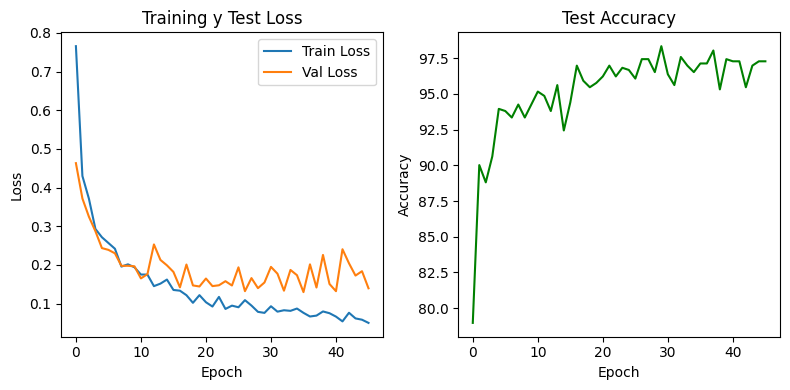

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].plot(train_loss_acumulado, label='Train Loss')
axes[0].plot(val_loss_acumulado, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Training y Test Loss')

axes[1].plot(accuracy_acumulado, label='Test Accuracy', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

***
<span style="font-family:Cambria Math">

# 7. Referencias
</span>

***
<span style="font-family:Cambria Math">

[¹] **Pytorch, entrenando un clasificador**  
Disponible en: [Pytorch.org](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

[²] **MRI sequences (overview), Radiopaedia.org**  
Disponible en: [radiopaedia.org](https://radiopaedia.org/articles/mri-sequences-overview?embed_domain=staging.radpair.comfavicon.icofavicon.icoradiopaedia-icon-144.png&lang=us)

[³] **Image Normalization in PyTorch**  
Disponible en: [medium.com](https://medium.com/%40piyushkashyap045/image-normalization-in-pytorch-from-tensor-conversion-to-scaling-3951b6337bc8)

[⁴] **Harnessing Python and SHA-256: An intuitive guide to removing duplicate files**  
Disponible en: [medium.com](https://medium.com/gitconnected/harnessing-python-and-sha-256-an-intuitive-guide-to-removing-duplicate-files-d3b02e0b3978)

[⁵] **AlexNet, by Pytorch Team**  
Disponible en: [pytorch.org](https://pytorch.org/hub/pytorch_vision_alexnet/)

[⁶] **Lazy Evaluation (Wikipedia)**

Disponible en: [en.wikipedia.org](https://en.wikipedia.org/wiki/Lazy_evaluation)

[⁷] **PyTorch Dataset Class**

Disponible en: [pytorch.org](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
</span>
